### Data Mid-bootcamp project classification

In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from category_encoders import OrdinalEncoder 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score, roc_curve, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE

### 0. Project details

***Goal: build a model that will provide insight into why some bank customers accept credit card offers***

**Definitions:**
- Customer Number: A sequential number assigned to the customers (this column is hidden and excluded – this unique identifier will not be used directly).
- Offer Accepted (**target variable**): Did the customer accept (Yes) or reject (No) the offer. Reward: The type of reward program offered for the card.
- Mailer Type: Letter or postcard.
- Income Level: Low, Medium or High.
- #Bank Accounts Open: How many non-credit-card accounts are held by the customer.
- Overdraft Protection: Does the customer have overdraft protection on their checking account(s) (Yes or No).
- Credit Rating: Low, Medium or High.
- #Credit Cards Held: The number of credit cards held at the bank.
- #Homes Owned: The number of homes owned by the customer.
- Household Size: Number of individuals in the family.
- Own Your Home: Does the customer own their home? (Yes or No).
- Average Balance: Average account balance (across all accounts over time). Q1, Q2, Q3 and Q4
- Balance: Average balance for each quarter in the last year

### 1. Getting data
- Read the `.csv` file.

In [2]:
data = pd.read_csv('data/creditcardmarketing_copy.csv')
data.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


### 2. Cleaning/Wrangling/EDA

- Rename columns with the PEP 8 (snake case)
- Check: info, shape, descriptive statistics, NaN, duplicated and blank values
    

In [3]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.columns

Index(['customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', '#_bank_accounts_open', 'overdraft_protection',
       'credit_rating', '#_credit_cards_held', '#_homes_owned',
       'household_size', 'own_your_home', 'average_balance', 'q1_balance',
       'q2_balance', 'q3_balance', 'q4_balance'],
      dtype='object')

In [4]:
print(data.shape)
print('------------')
data.isna().sum()/len(data)

(18000, 17)
------------


customer_number         0.000000
offer_accepted          0.000000
reward                  0.000000
mailer_type             0.000000
income_level            0.000000
#_bank_accounts_open    0.000000
overdraft_protection    0.000000
credit_rating           0.000000
#_credit_cards_held     0.000000
#_homes_owned           0.000000
household_size          0.000000
own_your_home           0.000000
average_balance         0.001333
q1_balance              0.001333
q2_balance              0.001333
q3_balance              0.001333
q4_balance              0.001333
dtype: float64

In [5]:
# It is observed that there are 5 columns with 24 null values, which represents less than 0.5%

In [6]:
data = data.dropna()
data.shape

(17976, 17)

In [7]:
# Nulls are removed because they are too few.

In [8]:
data.duplicated().sum()

0

In [9]:
# There are no duplicated values.

In [10]:
#The count of values are calculated, except for those columns with many unique values.
for x in data.columns:
    if not x in ['customer_number','average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']:
        print(x)
        print(data[x].value_counts())
        print('------')

offer_accepted
No     16955
Yes     1021
Name: offer_accepted, dtype: int64
------
reward
Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64
------
mailer_type
Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64
------
income_level
Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64
------
#_bank_accounts_open
1    13674
2     4007
3      295
Name: #_bank_accounts_open, dtype: int64
------
overdraft_protection
No     15300
Yes     2676
Name: overdraft_protection, dtype: int64
------
credit_rating
High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64
------
#_credit_cards_held
2    7933
1    6147
3    3381
4     515
Name: #_credit_cards_held, dtype: int64
------
#_homes_owned
1    14502
2     3289
3      185
Name: #_homes_owned, dtype: int64
------
household_size
3    5705
4    5532
5    2851
2    2809
1     539
6     538
8       1
9       1
Name: household_size, dtype: int64
------
own_your_h

In [11]:
# In some columns such as offer_accepted a data imbalance is observed that will be analyzed later.

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_number,17976.0,8999.727192,5196.958865,1.00,4498.75,9000.5,13501.25,18000.00
#_bank_accounts_open,17976.0,1.255730,0.472405,1.00,1.00,1.0,1.00,3.00
#_credit_cards_held,17976.0,1.903427,0.797086,1.00,1.00,2.0,2.00,4.00
#_homes_owned,17976.0,1.203549,0.427446,1.00,1.00,1.0,1.00,3.00
household_size,17976.0,3.499110,1.114476,1.00,3.00,3.0,4.00,9.00
average_balance,17976.0,940.515562,350.297837,48.25,787.50,1007.0,1153.25,3366.25
q1_balance,17976.0,910.450656,620.077060,0.00,392.75,772.0,1521.00,3450.00
q2_balance,17976.0,999.392190,457.402268,0.00,663.00,1032.0,1342.00,3421.00
q3_balance,17976.0,1042.033600,553.452599,0.00,633.00,945.5,1463.00,3823.00
q4_balance,17976.0,810.185803,559.001365,0.00,363.00,703.0,1212.00,4215.00


- For the columns from average_balance hereinafter, the data is observed to be very far from the mean, according to its standard deviation.
- Also, they have a bias to the left.
- The average balance of all customers is 940. 
- As the year goes by, this average/mean increases, with the exception of the last quarter (q4) which decreases.

### 3. Processing Data

#### 3.1 Numerical columns and its plots.

##### - Plots

In [13]:
num_df = data.select_dtypes('number')
num_df

,customer_number,#_bank_accounts_open,#_credit_cards_held,#_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,2,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,3,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,4,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,5,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...
17995,17996,1,1,1,5,167.50,136.0,65.0,71.0,398.0
17996,17997,1,3,1,3,850.50,984.0,940.0,943.0,535.0
17997,17998,1,2,1,4,1087.25,918.0,767.0,1170.0,1494.0
17998,17999,1,4,2,2,1022.25,626.0,983.0,865.0,1615.0


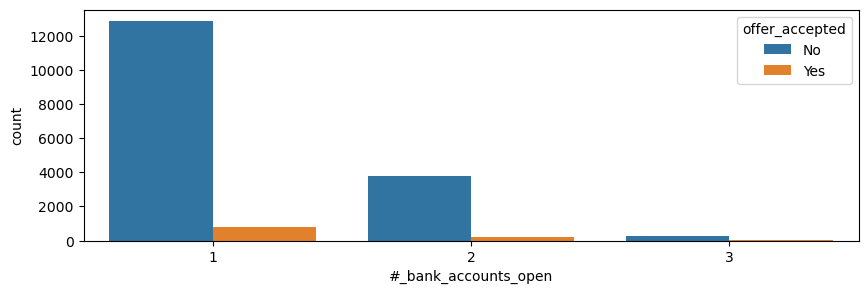

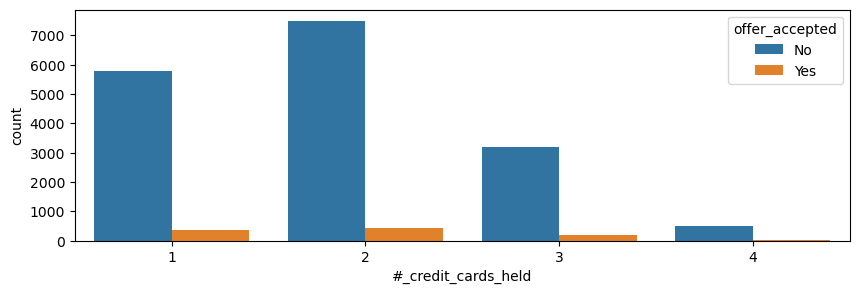

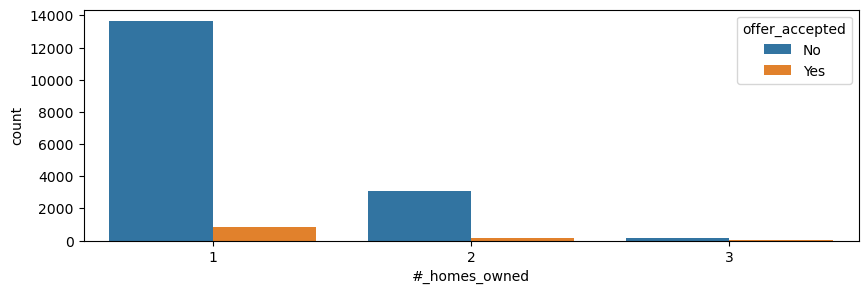

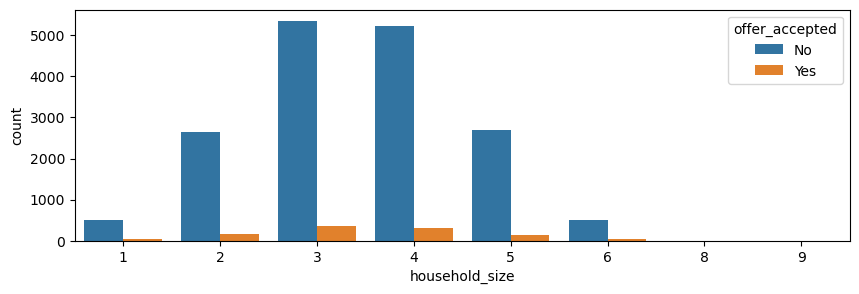

In [14]:
# A countplot is used for discrete variables

for column in num_df.columns[0:5]:
    if not column in ['customer_number']:
        plt.figure(figsize=(10,3))
        sns.countplot(data=data, x=num_df[column], hue=data['offer_accepted'])
        plt.show()

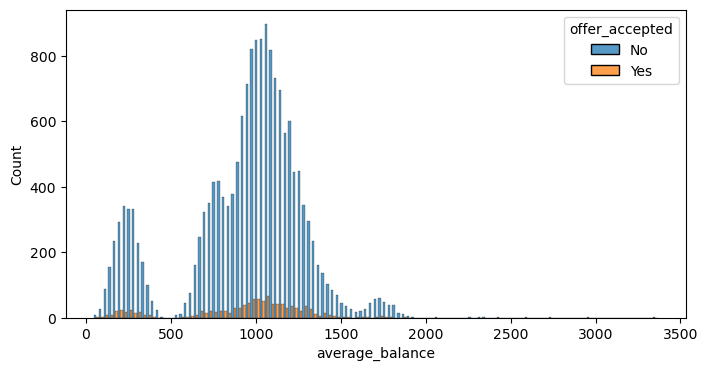

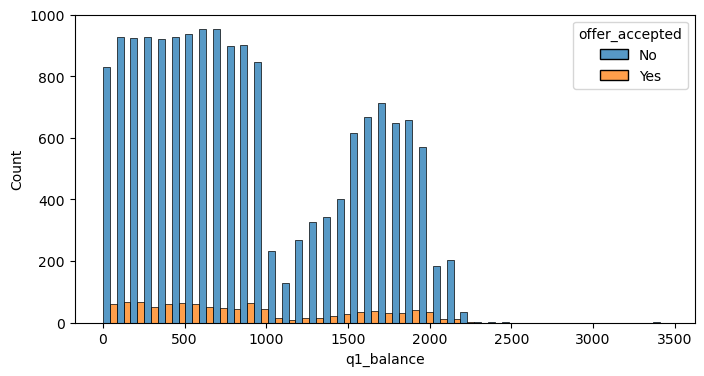

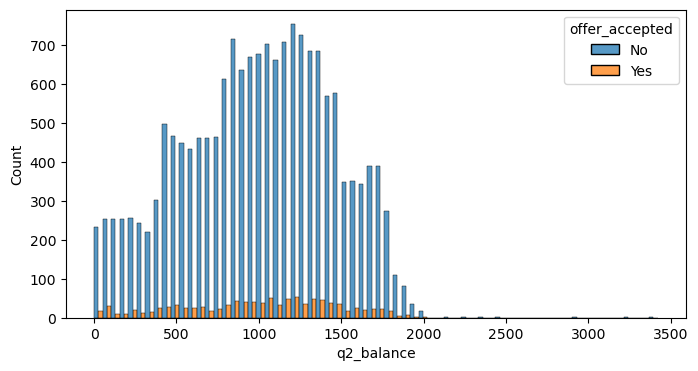

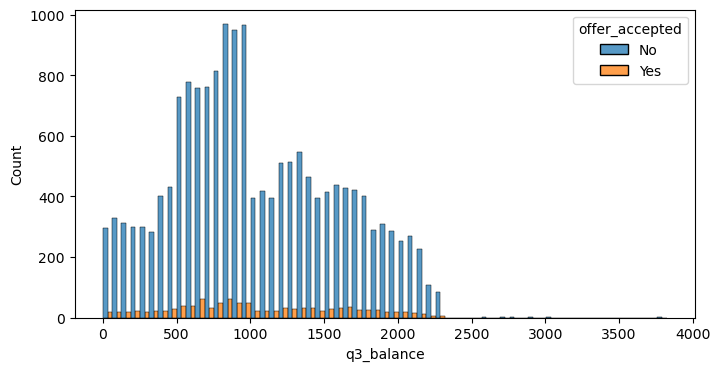

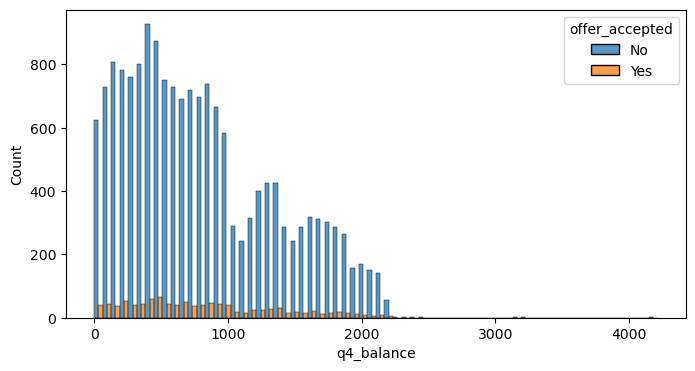

In [15]:
for column in num_df.columns[5:10]:
    plt.figure(figsize=(8,4))
    sns.histplot(data=data, x=column, hue='offer_accepted', multiple='dodge')
    plt.show()

##### - Checking multicollinearity

<Axes: >

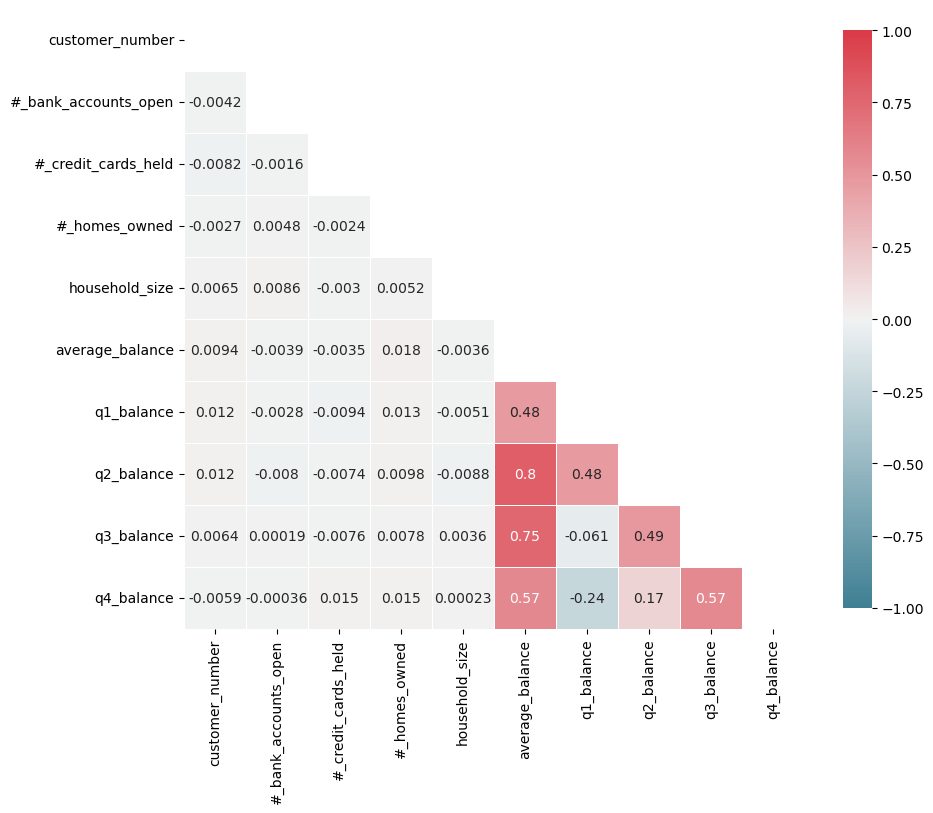

In [16]:
corr = num_df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))                                 
cmap = sns.diverging_palette(2020, 10, as_cmap = True)                          
plt.figure(figsize = (10, 10))                                                     
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1, annot = True,
            square = True, linewidths = 0.5, cbar_kws = {'shrink' : 0.75})

In [17]:
# The column average_balance may be removed, as this is the average of the balances for each quarter

In [18]:
considered_features = num_df.columns

In [19]:
# compute the vif for all given features
def compute_vif(df,considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [20]:
# compute vif 
compute_vif(num_df,considered_features).sort_values('VIF', ascending=False)

C:\Users\Daniel Castañeda\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
5,average_balance,inf
6,q1_balance,inf
7,q2_balance,inf
8,q3_balance,inf
9,q4_balance,inf
2,#_credit_cards_held,1.000728
3,#_homes_owned,1.000585
0,customer_number,1.000413
4,household_size,1.000331
1,#_bank_accounts_open,1.000213


In [21]:
num_df_2 = num_df.drop(['average_balance'], axis=1)

In [22]:
considered_features = num_df_2.columns

In [23]:
compute_vif(num_df_2,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
7,q3_balance,2.028179
6,q2_balance,2.008013
5,q1_balance,1.599509
8,q4_balance,1.565934
2,#_credit_cards_held,1.000728
3,#_homes_owned,1.000585
0,customer_number,1.000413
4,household_size,1.000331
1,#_bank_accounts_open,1.000213


##### - Checking outliers

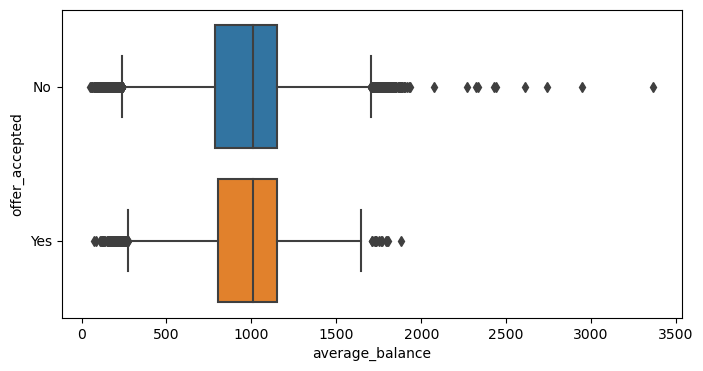

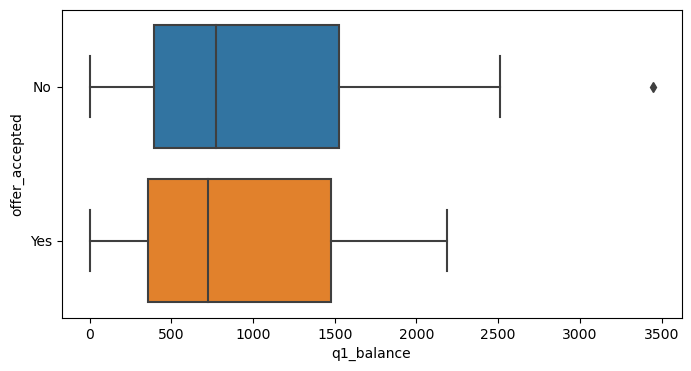

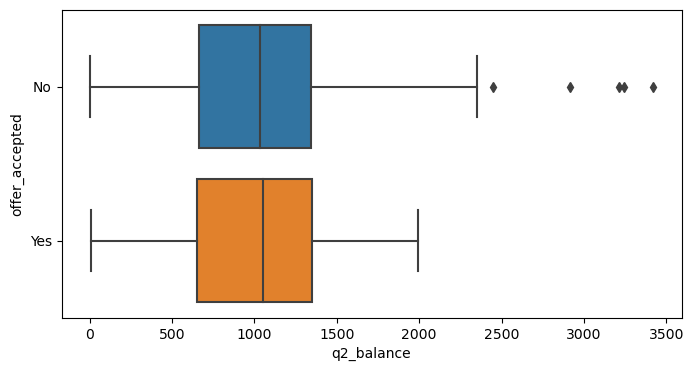

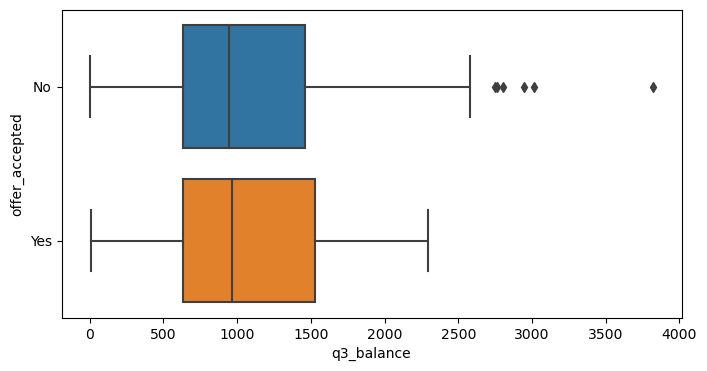

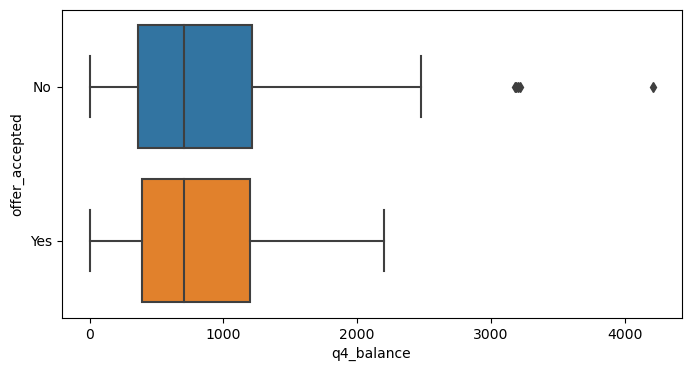

In [24]:
for column in num_df.columns[5:10]:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=data, x=column, y='offer_accepted')
    plt.show()

In [25]:
# The interquartile range (IQR) is calculated to count how many outliers there are and possibly filter/remove them.

q1=np.percentile(num_df['average_balance'], 25)   # percentile 25
q3=np.percentile(num_df['average_balance'], 75)   # percentile 75
iqr=q3-q1 

upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr

average_balance_outliers = num_df[(num_df['average_balance']<lower_limit) | (num_df['average_balance']>upper_limit)]
print(len(average_balance_outliers))
print(num_df.average_balance.shape)
len(average_balance_outliers)/num_df.average_balance.shape[0]

1441
(17976,)


0.08016243880729862

In [26]:
# A data frame is obtained for those values less than the lower limit and greater than the upper limit. 
# This is done to know how many outliers there are.

In [27]:
q1=np.percentile(num_df['q1_balance'], 25)   # percentile 25
q3=np.percentile(num_df['q1_balance'], 75)   # percentile 75
iqr=q3-q1 

upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr

q1_balance_outliers = num_df[(num_df['q1_balance']<lower_limit) | (num_df['q1_balance']>upper_limit)]
print(len(q1_balance_outliers))
print(num_df.average_balance.shape)
len(q1_balance_outliers)/num_df.average_balance.shape[0]

1
(17976,)


5.562972852692479e-05

In [28]:
q1=np.percentile(num_df['q2_balance'], 25)   # percentile 25
q3=np.percentile(num_df['q2_balance'], 75)   # percentile 75
iqr=q3-q1 

upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr

q2_balance_outliers = num_df[(num_df['q2_balance']<lower_limit) | (num_df['q2_balance']>upper_limit)]
print(len(q2_balance_outliers))
print(num_df.average_balance.shape)
len(q2_balance_outliers)/num_df.average_balance.shape[0]

5
(17976,)


0.00027814864263462394

In [29]:
q1=np.percentile(num_df['q3_balance'], 25)   # percentile 25
q3=np.percentile(num_df['q3_balance'], 75)   # percentile 75
iqr=q3-q1 

upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr

q3_balance_outliers = num_df[(num_df['q3_balance']<lower_limit) | (num_df['q3_balance']>upper_limit)]
print(len(q3_balance_outliers))
print(num_df.average_balance.shape)
len(q3_balance_outliers)/num_df.average_balance.shape[0]

6
(17976,)


0.0003337783711615487

In [30]:
q1=np.percentile(num_df['q4_balance'], 25)   # percentile 25
q3=np.percentile(num_df['q4_balance'], 75)   # percentile 75
iqr=q3-q1 

upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr

q4_balance_outliers = num_df[(num_df['q4_balance']<lower_limit) | (num_df['q4_balance']>upper_limit)]
print(len(q4_balance_outliers))
print(num_df.average_balance.shape)
len(q4_balance_outliers)/num_df.average_balance.shape[0]

5
(17976,)


0.00027814864263462394

In [31]:
# For all columns except average_balance, outliers could be removed as they represent a percentage less than 0.5% 
# Outliers in average_balance represent 8%

#### 3.2 Categorical columns and its plots.

##### - Plots

In [32]:
cat_df = data.select_dtypes('object')
cat_df.head(3)

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes


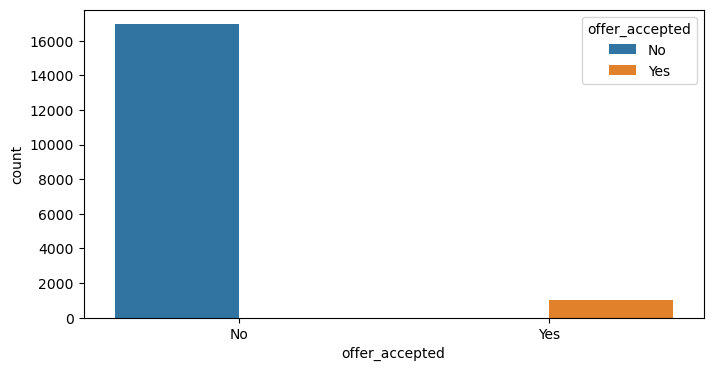

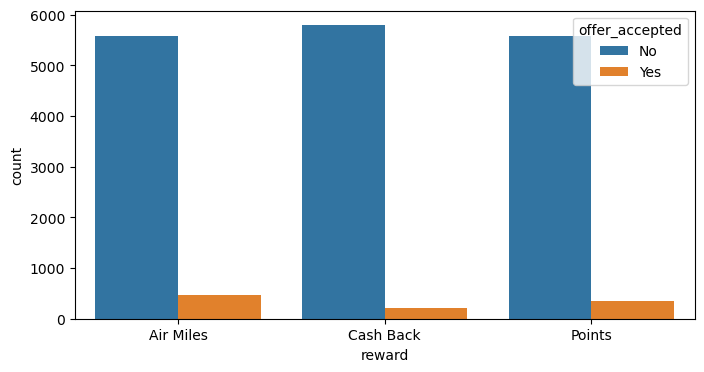

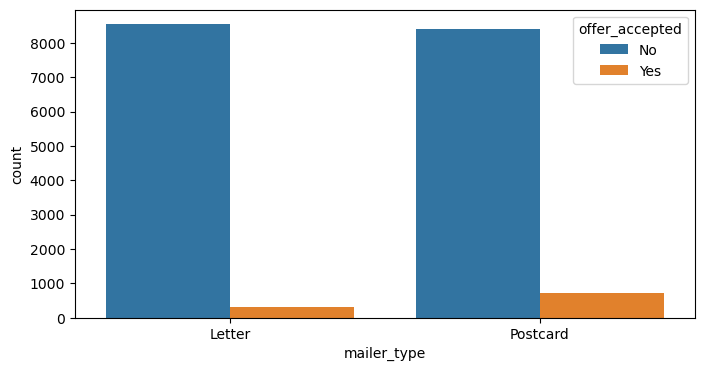

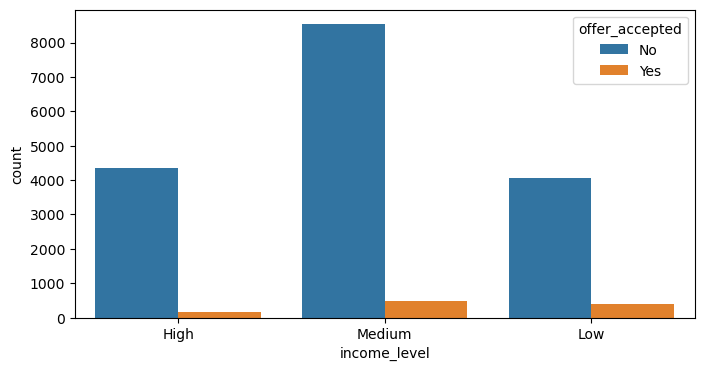

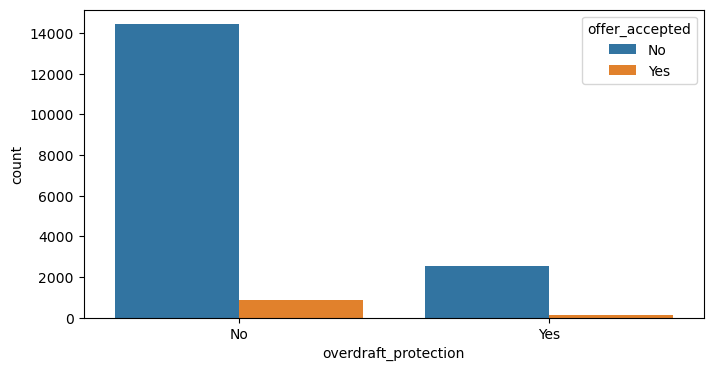

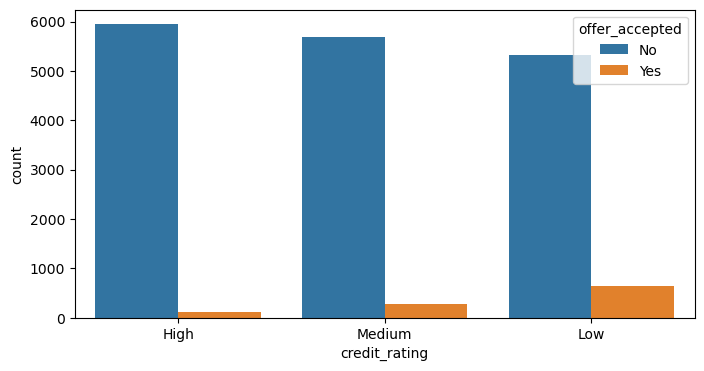

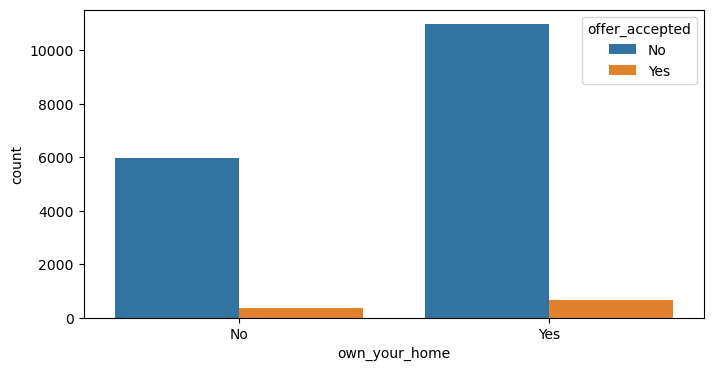

In [33]:
for column in cat_df.columns[0:7]:
    if not column in ['customer_number']:
        plt.figure(figsize=(8,4))
        sns.countplot(data=data, x=cat_df[column], hue=data['offer_accepted'])
        plt.show()

##### - Encoding

In [34]:
# For those columns that do not have a specific order, One-Hot Encoder is used, to encode each  
# category of the columns into a binary column, where 1 indicates yes and 0 indicates no.

In [35]:
for column in cat_df.columns:
     if column in ['offer_accepted', 'mailer_type','overdraft_protection', 'own_your_home']:
        enc = preprocessing.OneHotEncoder(drop='first', sparse_output=False)
        cat_df[column] = enc.fit_transform(cat_df[[column]])
        cat_df[column] = pd.DataFrame(cat_df[column])

In [36]:
cat_df.head(3)

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,0.0,Air Miles,0.0,High,0.0,High,0.0
1,0.0,Air Miles,0.0,Medium,0.0,Medium,1.0
2,0.0,Air Miles,1.0,High,0.0,Medium,1.0


In [37]:
# For the reward column, the get_dummies encoder is used to create binary columns for each category.

dummies_encoder = pd.get_dummies(cat_df, drop_first=True, columns=['reward'])
dummies_encoder.head(3)

,offer_accepted,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,reward_Cash Back,reward_Points
0,0.0,0.0,High,0.0,High,0.0,0,0
1,0.0,0.0,Medium,0.0,Medium,1.0,0,0
2,0.0,1.0,High,0.0,Medium,1.0,0,0


In [38]:
# We remove the columns that are not encoded, such as income_leve and credit_rating, 
# so that it is later concatenated with the encoded dataframes.

dummies_encoder.drop(['income_level', 'credit_rating'], axis=1, inplace=True)
dummies_encoder

,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_Cash Back,reward_Points
0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,1.0,0,0
2,0.0,1.0,0.0,1.0,0,0
3,0.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...
17995,0.0,0.0,0.0,1.0,1,0
17996,0.0,0.0,0.0,1.0,1,0
17997,0.0,0.0,0.0,0.0,1,0
17998,0.0,0.0,0.0,1.0,1,0


In [39]:
# And for those columns that have a specific order, ordinal_encoder is used.

maplist = [{'col': 'income_level', 'mapping': {'Low': 0, 'Medium': 1,'High': 2}}]
oe = OrdinalEncoder(mapping=maplist)
oe_income_level = oe.fit_transform(cat_df['income_level'])
oe_income_level = pd.DataFrame(oe_income_level, columns=['income_level'])
oe_income_level.head(3)

,income_level
0,2
1,1
2,2


In [40]:
maplist = [{'col': 'credit_rating', 'mapping': {'Low': 0, 'Medium': 1,'High': 2}}]
oe = OrdinalEncoder(mapping=maplist)
oe_credit_rating = oe.fit_transform(cat_df['credit_rating'])
oe_credit_rating = pd.DataFrame(oe_credit_rating, columns=['credit_rating'])
oe_credit_rating.head(3)

,credit_rating
0,2
1,1
2,1


In [41]:
#Create a categorical dataframe with coded columns
categorical_df = pd.concat([oe_credit_rating, oe_income_level, dummies_encoder], axis=1)
categorical_df

,credit_rating,income_level,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_Cash Back,reward_Points
0,2,2,0.0,0.0,0.0,0.0,0,0
1,1,1,0.0,0.0,0.0,1.0,0,0
2,1,2,0.0,1.0,0.0,1.0,0,0
3,2,1,0.0,0.0,0.0,0.0,0,0
4,1,1,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...
17995,0,2,0.0,0.0,0.0,1.0,1,0
17996,0,2,0.0,0.0,0.0,1.0,1,0
17997,0,2,0.0,0.0,0.0,0.0,1,0
17998,1,1,0.0,0.0,0.0,1.0,1,0


In [42]:
categorical_df.columns = categorical_df.columns.str.replace(' ', '_').str.lower()
categorical_df.head(2)

,credit_rating,income_level,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_cash_back,reward_points
0,2,2,0.0,0.0,0.0,0.0,0,0
1,1,1,0.0,0.0,0.0,1.0,0,0


In [43]:
dataframe = pd.concat([categorical_df, num_df], axis=1)
dataframe

,credit_rating,income_level,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_cash_back,reward_points,customer_number,#_bank_accounts_open,#_credit_cards_held,#_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,2,2,0.0,0.0,0.0,0.0,0,0,1,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,1,1,0.0,0.0,0.0,1.0,0,0,2,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,1,2,0.0,1.0,0.0,1.0,0,0,3,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,2,1,0.0,0.0,0.0,0.0,0,0,4,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,1,1,0.0,0.0,0.0,1.0,0,0,5,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0,2,0.0,0.0,0.0,1.0,1,0,17996,1,1,1,5,167.50,136.0,65.0,71.0,398.0
17996,0,2,0.0,0.0,0.0,1.0,1,0,17997,1,3,1,3,850.50,984.0,940.0,943.0,535.0
17997,0,2,0.0,0.0,0.0,0.0,1,0,17998,1,2,1,4,1087.25,918.0,767.0,1170.0,1494.0
17998,1,1,0.0,0.0,0.0,1.0,1,0,17999,1,4,2,2,1022.25,626.0,983.0,865.0,1615.0


### 4. Model

In [44]:
#Train test split

y = dataframe.offer_accepted
X = dataframe.drop(['offer_accepted'], axis=1)
print(y.shape, X.shape)

(17976,) (17976, 17)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13482, 17), (4494, 17), (13482,), (4494,))

In [46]:
#Create and fit our regression model

lr = LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [47]:
#Make predictions for train
y_train_pred = lr.predict(X_train)
y_train_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
#Make predictions for test
y_pred_test = lr.predict(X_test)
y_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
#Evaluation of the model with the confusion matrix

In [50]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train

array([[12714,     0],
       [  768,     0]], dtype=int64)

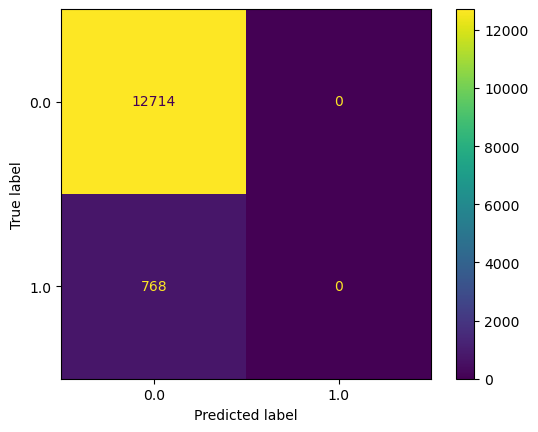

In [51]:
#Display confusion matrix for train data
disp = ConfusionMatrixDisplay(cm_train, display_labels=lr.classes_)
disp.plot()
plt.show()

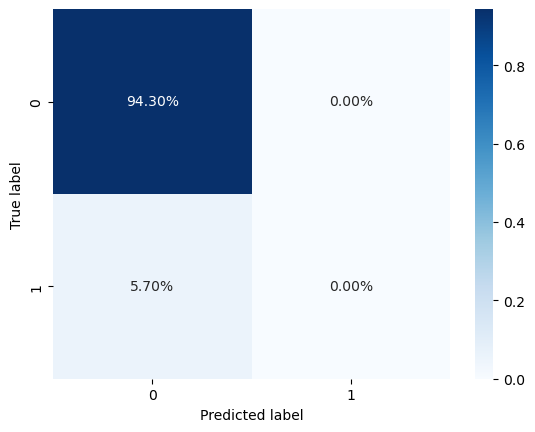

In [52]:
#Confusion matrix using seaborn and percentages for train data
ax = sns.heatmap(cm_train/np.sum(cm_train), annot=True, fmt='.2%', cmap='Blues')
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

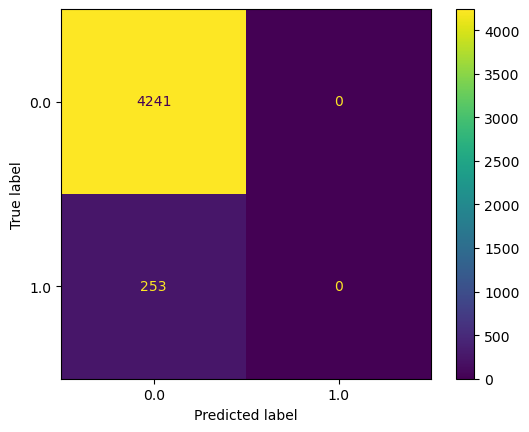

In [53]:
#Now for test
cm_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

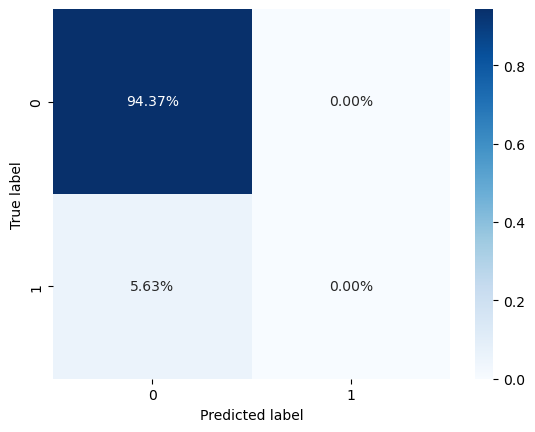

In [54]:
#Confusion matrix using seaborn and percentages for train data
ax = sns.heatmap(cm_test/np.sum(cm_test), annot=True, fmt='.2%', cmap='Blues')
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

In [55]:
print("The accuracy of the model in the TRAIN set is: {:.2f}".format(lr.score(X_train, y_train)))
print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_test, y_test)))

The accuracy of the model in the TRAIN set is: 0.94
The accuracy of the model in the TEST set is: 0.94


### 5. Imbalance and metrics

##### 5.1 Class imbalance (CI) and proportion

In [56]:
count_classes = dataframe['offer_accepted'].value_counts()
print(count_classes[0], count_classes[1])
print('--------')
print(dataframe.shape[0])

16955 1021
--------
17976


In [57]:
(count_classes[0]-count_classes[1]) / (count_classes[0]+count_classes[1])

0.8864040943480196

In [58]:
count_classes[1] / count_classes[0]+count_classes[1]

1021.0602182247125

In [59]:
# 94% of the sample is 0 (customer reject the offer) and 6% is 1 (customer accept the offer)

##### 5.2 Metrics 

TP.- True postive  
TN.- True negative  
FP.- False positive  
FN.- False negative  

- Accuracy score = (TP + TN)/(TP + TN + FP + FN) 
- Precision score = TP/(TP + FP)
- Recall or sensivity score = TP / (TP + FN)
- F1 score = 2*((precision*recall)/(precision+recall))

In [60]:
print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.94
The precision in the TEST set is: 0.00
The recall in the TEST set is: 0.00
The F1 in the TEST set is: 0.00
The Kappa in the TEST set is: 0.00


C:\Users\Daniel Castañeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 5.3 Oversampling the minority class

Any resampling (oversampling, undersampling, SMOTE) is only to be done on the TRAINING set   
**Our test set still must reflect reality (which has imbalance)!**

In [61]:
y_train[y_train== 0].shape

(12714,)

In [62]:
y_train.value_counts()

0.0    12714
1.0      768
Name: offer_accepted, dtype: int64

In [63]:
ros = RandomOverSampler(random_state=42)
ros

RandomOverSampler(random_state=42)

In [64]:
X_train_over, y_train_over = ros.fit_resample(X_train,y_train)
y_train_over.value_counts()

0.0    12714
1.0    12714
Name: offer_accepted, dtype: int64

In [65]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_over, y_train_over)
y_pred_test = lr.predict(X_test)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.67
The precision in the TEST set is: 0.12
The recall in the TEST set is: 0.73
The F1 in the TEST set is: 0.20
The Kappa in the TEST set is: 0.11


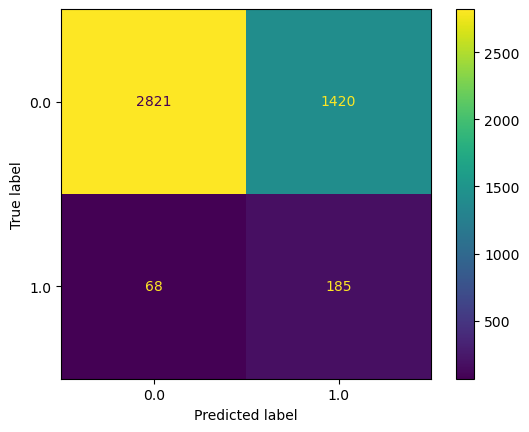

In [66]:
cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

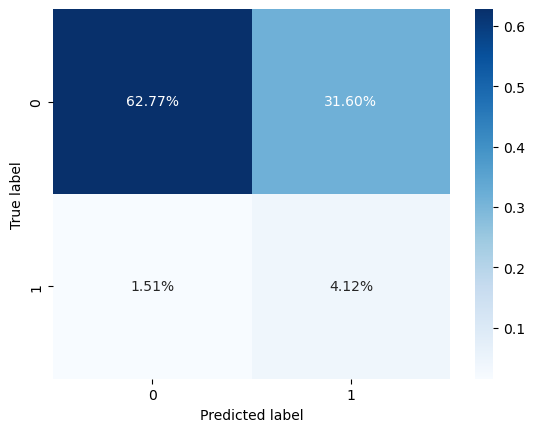

In [67]:
ax = sns.heatmap(cm_test/np.sum(cm_test), annot=True, fmt='.2%', cmap='Blues')
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

##### 5.4 Undersampling the majority class

In [68]:
y_train[y_train== 1].shape

(768,)

In [69]:
y_train.value_counts()

0.0    12714
1.0      768
Name: offer_accepted, dtype: int64

In [70]:
rus = RandomUnderSampler(random_state=42)

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
y_train_under.value_counts()

0.0    768
1.0    768
Name: offer_accepted, dtype: int64

In [71]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_under, y_train_under)
y_pred_test = lr.predict(X_test)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.67
The precision in the TEST set is: 0.11
The recall in the TEST set is: 0.72
The F1 in the TEST set is: 0.20
The Kappa in the TEST set is: 0.11


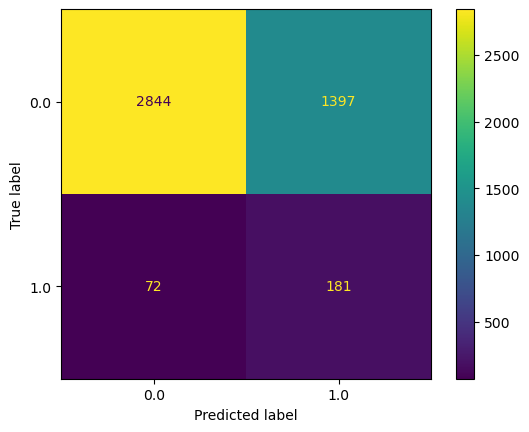

In [72]:
cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

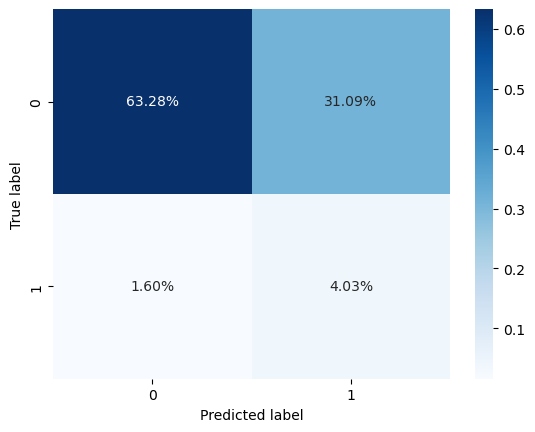

In [73]:
ax = sns.heatmap(cm_test/np.sum(cm_test), annot=True, fmt='.2%', cmap='Blues')
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

##### 5.5 Synthetic Minority Over-sampling Technique (SMOTE)

Increases the number of instances in the minority class by generating synthetic examples.

In [74]:
sm = SMOTE(random_state=100, k_neighbors=5)

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

In [75]:
y_train_SMOTE.value_counts()

0.0    12714
1.0    12714
Name: offer_accepted, dtype: int64

In [76]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_test = lr.predict(X_test)

print("model with SMOTE")
print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

model with SMOTE
The accuracy in the TEST set is: 0.81
The precision in the TEST set is: 0.14
The recall in the TEST set is: 0.45
The F1 in the TEST set is: 0.21
The Kappa in the TEST set is: 0.14


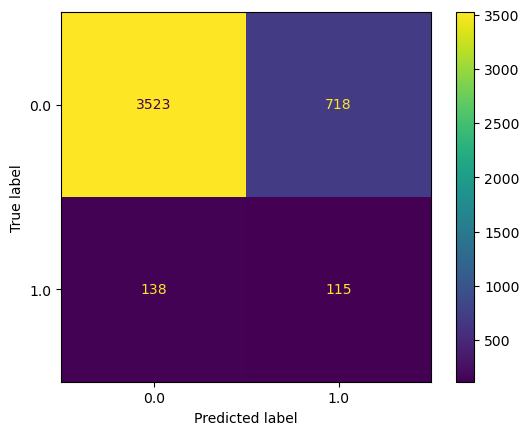

In [77]:
cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

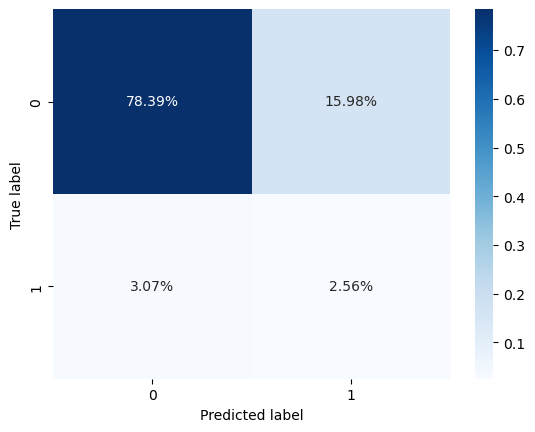

In [78]:
ax = sns.heatmap(cm_test/np.sum(cm_test), annot=True, fmt='.2%', cmap='Blues')
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

### 6. Improving the model

In [79]:
dataframe.head()

,credit_rating,income_level,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_cash_back,reward_points,customer_number,#_bank_accounts_open,#_credit_cards_held,#_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,2,2,0.0,0.0,0.0,0.0,0,0,1,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,1,1,0.0,0.0,0.0,1.0,0,0,2,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,1,2,0.0,1.0,0.0,1.0,0,0,3,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,2,1,0.0,0.0,0.0,0.0,0,0,4,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,1,1,0.0,0.0,0.0,1.0,0,0,5,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0


##### 6.1 Average_balance removal (ar)

In [80]:
ar_df = dataframe.drop(['average_balance'], axis=1)
print(ar_df.shape)
ar_df.head(2)

(17976, 17)


,credit_rating,income_level,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_cash_back,reward_points,customer_number,#_bank_accounts_open,#_credit_cards_held,#_homes_owned,household_size,q1_balance,q2_balance,q3_balance,q4_balance
0,2,2,0.0,0.0,0.0,0.0,0,0,1,1,2,1,4,1669.0,877.0,1095.0,1002.0
1,1,1,0.0,0.0,0.0,1.0,0,0,2,1,2,2,5,39.0,106.0,78.0,366.0


In [81]:
ar_df = ar_df[(ar_df['q1_balance']>lower_limit) & (ar_df['q1_balance']<upper_limit)]
ar_df = ar_df[(ar_df['q2_balance']>lower_limit) & (ar_df['q2_balance']<upper_limit)]
ar_df = ar_df[(ar_df['q3_balance']>lower_limit) & (ar_df['q3_balance']<upper_limit)]
ar_df = ar_df[(ar_df['q4_balance']>lower_limit) & (ar_df['q4_balance']<upper_limit)]
ar_df.shape

(17965, 17)

In [82]:
y_ar = ar_df.offer_accepted
X_ar = ar_df.drop(['offer_accepted'], axis=1)

In [83]:
X_train_ar, X_test_ar, y_train_ar, y_test_ar = train_test_split(X_ar, y_ar, test_size=0.25, random_state=42)

In [84]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
lr.fit(X_train_ar, y_train_ar)

LogisticRegression(max_iter=1000, random_state=0)

In [85]:
y_train_pred_ar = lr.predict(X_train_ar)
y_pred_test_ar = lr.predict(X_test_ar)

In [86]:
ros = RandomOverSampler(random_state=42)
X_train_over_ar, y_train_over_ar = ros.fit_resample(X_train_ar,y_train_ar)

In [87]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_over_ar, y_train_over_ar)
y_pred_test_ar = lr.predict(X_test_ar)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test_ar,y_pred_test_ar)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test_ar,y_pred_test_ar)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test_ar,y_pred_test_ar)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test_ar,y_pred_test_ar)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test_ar,y_pred_test_ar)))

The accuracy in the TEST set is: 0.66
The precision in the TEST set is: 0.11
The recall in the TEST set is: 0.70
The F1 in the TEST set is: 0.20
The Kappa in the TEST set is: 0.10


In [88]:
# Decreases the values of accuracy, precision and recall.

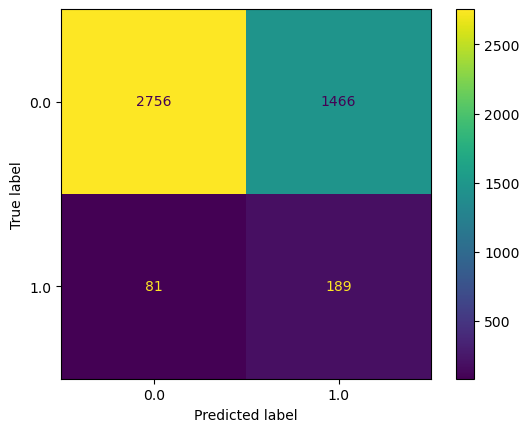

In [89]:
cm_test = confusion_matrix(y_test_ar,y_pred_test_ar)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

##### 6.2 Quarters columns removal (qr)

In [90]:
qr_df = dataframe.drop(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'], axis=1)
qr_df.head(2)

,credit_rating,income_level,offer_accepted,mailer_type,overdraft_protection,own_your_home,reward_cash_back,reward_points,customer_number,#_bank_accounts_open,#_credit_cards_held,#_homes_owned,household_size,average_balance
0,2,2,0.0,0.0,0.0,0.0,0,0,1,1,2,1,4,1160.75
1,1,1,0.0,0.0,0.0,1.0,0,0,2,1,2,2,5,147.25


In [91]:
y_qr = ar_df.offer_accepted
X_qr = ar_df.drop(['offer_accepted'], axis=1)

In [92]:
X_train_qr, X_test_qr, y_train_qr, y_test_qr = train_test_split(X_qr, y_qr, test_size=0.25, random_state=42)

In [93]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
lr.fit(X_train_qr, y_train_qr)

LogisticRegression(max_iter=1000, random_state=0)

In [94]:
y_train_pred_qr = lr.predict(X_train_qr)
y_pred_test_qr = lr.predict(X_test_qr)

In [95]:
ros = RandomOverSampler(random_state=42)
X_train_over_qr, y_train_over_qr = ros.fit_resample(X_train_qr,y_train_qr)

In [96]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_over_qr, y_train_over_qr)
y_pred_test_qr = lr.predict(X_test_qr)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test_qr,y_pred_test_qr)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test_qr,y_pred_test_qr)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test_qr,y_pred_test_qr)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test_qr,y_pred_test_qr)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test_qr,y_pred_test_qr)))

The accuracy in the TEST set is: 0.66
The precision in the TEST set is: 0.11
The recall in the TEST set is: 0.70
The F1 in the TEST set is: 0.20
The Kappa in the TEST set is: 0.10


In [97]:
# Decreases the values of accuracy, precision and recall.
# Therefore, the best technique for treating imbalance data with this data set, is oversampling.

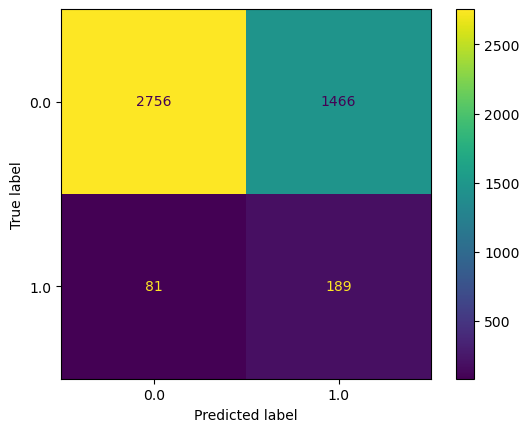

In [98]:
cm_test = confusion_matrix(y_test_qr,y_pred_test_qr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()